# Simulated Annealing


In [5]:
%matplotlib inline

# Pytorch libraries
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import random as rm
import numpy as np
import time
import copy

# Add the sibling folders
import sys, os
sys.path.insert(0, os.path.abspath('../..'))
import src.utils as ut

# Plot libraries and tables
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()

Let's define a basic NN, made out of two layers: the first one has 200 neurons, while the second one 50.

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Basic two-layer network
        self.fc1 = nn.Linear(28 * 28, 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):        
        # Get the batch size
        in_size = x.size(0)
        # Flatten data, -1 is inferred from the other dimensions
        x = x.view(in_size, -1) 
        
        # Forward rule
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # Softmax on predictions
        x = F.softmax(x, dim=1)
        
        return x

## The algorithm
The first implementation uses the **whole training set**, in order to avoid noisy evaluations. 
The epsilon variable allows to set the maximum movement in every direction. Each movement is done by creating a tensor for each layer $k$ called $ \Delta_k(w)$. The update is done according to the formula:

$$ w'  = w - \epsilon \Delta(w)  $$

where each value of each tensor  $ \Delta_k(w) $ is sampled from the distribution $ U (-1, 1) $. 

In the following implementation I wanted to try a first test without trying to make the best choice, in order to save some computation time. If $ L(w') > L(w) $ the opposite direction is chosen, i.e.

$$ w''  = w + \epsilon \ \Delta(w)  $$

even if $ L(w') < L(w'') $



In [7]:
def full_train_SA_noT(trainloader, model, accuracy_before, epsilon, gpu=True):
    model.train()
    
    # List to store the opposite direction - \Delta(w) for each layer
    inverse = []
    
    for param in net.parameters():
        # Replicate the tensor
        tensor_size = param.data.size()
        move = torch.zeros(tensor_size)
        # Send it to the GPU
        if gpu:
            move = move.cuda()
        # Generate move
        move = move.uniform_(-1, 1).mul(epsilon) * param.data
        # Stepback is saved
        inverse.append(move.mul(-2))
        # Move the parameters
        param.data.add_(move)
    
    # Evaluate the accuracy 
    new_accuracy = ut.test_train(train_loader, net)[1]

    if new_accuracy < accuracy_before:
        for k, param in enumerate(net.parameters()):
            param.data.add_(inverse[k])

        new_accuracy = ut.test_train(train_loader, net)[1]
    
    print("New accuracy: ", new_accuracy)
    return new_accuracy

Looking at the results (first plot below), it can be seen that both the directions do not often improve the accuracy. 

Now we can implement the full algorithm. $ L(w') $ and $ L(w'') $ are both evaulated:

$$ L_{best} = \min(L(w'),\ L(w'')) $$

If $ L_{best} < L(w) $, then accept the movement for sure; otherwise accept if $ x  > temperature $, where x is sampled from the uniform distribution $ U(0, 1) $.


In [8]:
def full_train_SA(trainloader, model, initial_accuracy, epsilon, T, gpu=True):
    model.train()
    
    # List used to keep the move to get back to the initial point
    inverse = []
    
    # First move
    for param in net.parameters():
        # Replicate the tensor
        tensor_size = param.data.size()
        move = torch.zeros(tensor_size)
        # Send it to the GPU
        if gpu:
            move = move.cuda()
        # Generate move
        move = move.uniform_(-1, 1).mul(epsilon) * param.data
        # Stepback is saved
        inverse.append(move.mul(-1)) 
        # Move the parameters
        param.data.add_(move)
    # Evaluate the accuracy 
    first_accuracy = ut.test_train(train_loader, net)[1]
    print("First move accuracy: ", first_accuracy)
    
    # Second move
    for k, param in enumerate(net.parameters()):
        param.data.add_(inverse[k].mul(2))
        inverse[k] = inverse[k].mul(-1)
    second_accuracy = ut.test_train(train_loader, net)[1]
    print("Second move accuracy:", second_accuracy)
    
    # Get back if the first accuracy is better
    if first_accuracy > second_accuracy:
        for k, param in enumerate(net.parameters()):
            param.data.add_(inverse[k].mul(2))
            inverse[k] = inverse[k].mul(-1)
        new_accuracy = first_accuracy
    else: new_accuracy = second_accuracy
    
    # Accept a worse solution according to temperature
    if new_accuracy < initial_accuracy and rm.uniform(0, 1) > T:
        for k, param in enumerate(net.parameters()):
            param.data.add_(inverse[k])
        new_accuracy = initial_accuracy
        
    del move, inverse
    print("Final accuracy:", new_accuracy)
    return new_accuracy


Let's test the first method.

In [24]:
# Parameters
epsilon = 10e-2
epochs = 2000

In [22]:
train_loader, test_loader = ut.load_dataset(dataset_name='mnist', minibatch=4096)

# Testing the first method
starting_time = time.time()
net = Net()
clone = copy.deepcopy(net)
net = net.cuda()
accuracy = ut.test_train(train_loader, net)[1]
training_set_measurements, validation_set_measurements, times = [], [], []

# Train
for epoch in range(epochs):
    print("Epoch: ", epoch)
    accuracy = full_train_SA_noT(train_loader, net, accuracy, epsilon)
    training_set_measurements.append(accuracy)
    validation_set_measurements.append(ut.test(test_loader, net)[1])
    times.append(time.time() - starting_time)
    
np.savez('no_temperature',
            training_set_measurements=[x * 100 for x in training_set_measurements],
            validation_set_measurements=[x * 100 for x in validation_set_measurements],
            times=[x / 60 for x in times])
del net

Then the second method, forcing a monotonic behaviour, by alwasy setting $ Temperature = 0 $.

In [23]:
# Testing the second method
net = clone.cuda()
accuracy = ut.test_train(train_loader, net)[1]
training_set_measurements, validation_set_measurements, times = [], [], []
starting_time = time.time()

for epoch in range(epochs):
    print("Epoch: ", epoch)
    accuracy = full_train_SA(train_loader, net, accuracy, epsilon, 0)
    training_set_measurements.append(accuracy)
    validation_set_measurements.append(ut.test(test_loader, net)[1])
    times.append(time.time() - starting_time)
    
np.savez('T=0',
            training_set_measurements=[x * 100 for x in training_set_measurements],
            validation_set_measurements=[x * 100 for x in validation_set_measurements],
            times=[x / 60 for x in times])

del net

Two plots: the first one with 'number of epochs' as x-axis, the second one comparing the accuracy vs computing time.

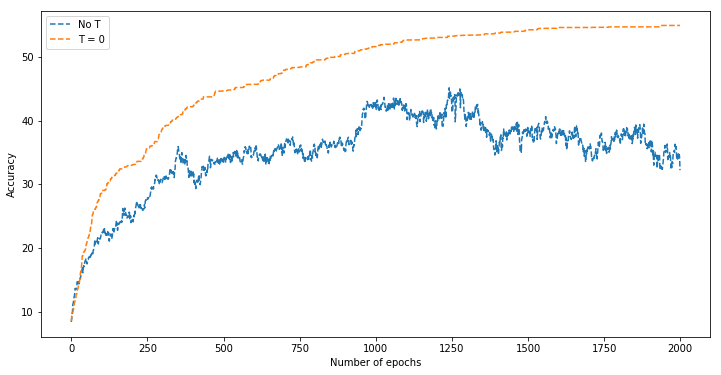

In [12]:
no_T = np.load('no_temperature.npz')
T_0 = np.load('T=0.npz')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, len(no_T['training_set_measurements'])), no_T['training_set_measurements'], '--', label='No T')
ax.plot(np.arange(0, len(T_0['training_set_measurements'])), T_0['training_set_measurements'], '--', label='T = 0')

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('')
ax.legend()
plt.show()

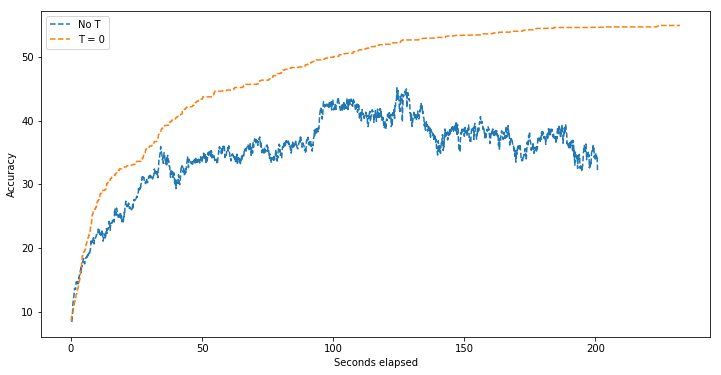

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(no_T['times'], no_T['training_set_measurements'], '--', label='No T')
ax.plot(T_0['times'], T_0['training_set_measurements'], '--', label='T = 0')

plt.xlabel('Minutes elapsed')
plt.ylabel('Accuracy')
ax.legend()
plt.show()

The first method is faster but it does not improve the accuracy. Some information about training and test acuracy in the following plots.

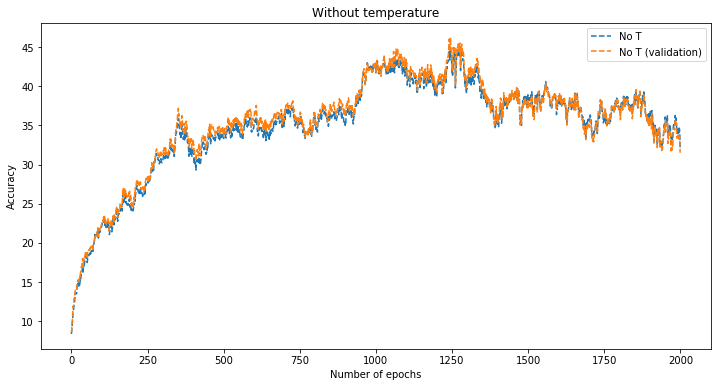

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, len(no_T['training_set_measurements'])), no_T['training_set_measurements'], '--', label='No T')
ax.plot(np.arange(0, len(no_T['validation_set_measurements'])), no_T['validation_set_measurements'], '--', label='No T (validation)')

plt.title('Without temperature')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
ax.legend()
plt.show()

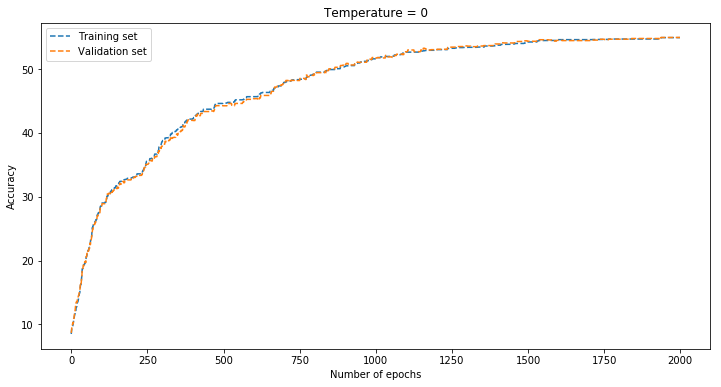

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.arange(0, len(T_0['training_set_measurements'])), T_0['training_set_measurements'], '--', label='Training set')
ax.plot(np.arange(0, len(T_0['validation_set_measurements'])), T_0['validation_set_measurements'], '--', label='Validation set')

plt.title('Temperature = 0')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
ax.legend()
plt.show()